Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

Load in the data

In [2]:
weather = pd.read_csv('./data/new-new-york-weather.csv', low_memory=False)
weather.shape

(368796, 15)

In [3]:
weather.dtypes

date                      object
temperature_2m_max        object
temperature_2m_min        object
daylight_duration         object
sunshine_duration         object
uv_index_max              object
uv_index_clear_sky_max    object
rain_sum                  object
showers_sum               object
snowfall_sum              object
precipitation_hours       object
wind_speed_10m_max        object
wind_gusts_10m_max        object
latitude                  object
longitude                 object
dtype: object

In [4]:
weather = weather.drop(columns = ['uv_index_max','uv_index_clear_sky_max'])

Drop strings in the dataframe that came from improper appending

In [5]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
5084,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
65675,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
126266,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
187023,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
247614,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
308205,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


In [6]:
weather = weather.drop(weather[weather['daylight_duration'].astype(str).str.contains('day')].index)

In [7]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


Sort the dataframe by date

In [8]:
weather = weather.sort_values('date')

Delete the time in all the dates and remove the white space made

In [9]:
weather['date'] = weather['date'].str.replace('05:00:00+00:00', '')
weather['date'] = weather['date'].str.strip()

In [10]:
weather.head()

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
291050,2005-01-01,6.0785,-1.6715,32634.35,20676.693,0.3,0.0,0.0,2.0,19.211996,46.8,43.1,-73.86
251630,2005-01-01,8.6855,-2.1145,32994.484,28458.79,0.2,0.0,0.0,2.0,23.73271,54.719997,42.1957,-78.6287
303460,2005-01-01,5.847,-2.803,32549.463,10120.855,0.2,0.0,0.0,1.0,17.873556,43.92,43.35,-73.42
260390,2005-01-01,7.4214997,-1.4285,32994.484,28465.23,0.1,0.0,0.0,1.0,19.67195,45.0,42.213,-74.982
260755,2005-01-01,5.9925,-2.6075,32994.484,28727.3,0.2,0.0,0.0,1.0,20.620804,47.88,42.1821,-74.9847


In [11]:
weather[['temperature_2m_max','temperature_2m_min',"daylight_duration","sunshine_duration","rain_sum",'showers_sum',
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]] = weather[['temperature_2m_max','temperature_2m_min',"daylight_duration","sunshine_duration","rain_sum",'showers_sum',
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]].apply(pd.to_numeric)

In [12]:
weather['precipitation_total'] = weather['rain_sum'] + weather['snowfall_sum'] 
weather['location'] = list(zip(weather['latitude'],weather['longitude']))

In [13]:
# Group by 'location'
grouped = weather.groupby('location')

# Drop duplicates based on 'date' for each group
weather = pd.concat([group.drop_duplicates(subset=['date']) for _, group in grouped], ignore_index=True)

# Display the first few rows of the cleaned DataFrame
weather.shape

(368790, 15)

In [14]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368790 entries, 0 to 368789
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 368790 non-null  object 
 1   temperature_2m_max   368790 non-null  float64
 2   temperature_2m_min   368790 non-null  float64
 3   daylight_duration    368790 non-null  float64
 4   sunshine_duration    368788 non-null  float64
 5   rain_sum             368790 non-null  float64
 6   showers_sum          368790 non-null  float64
 7   snowfall_sum         368790 non-null  float64
 8   precipitation_hours  368790 non-null  float64
 9   wind_speed_10m_max   368790 non-null  float64
 10  wind_gusts_10m_max   368790 non-null  float64
 11  latitude             368790 non-null  float64
 12  longitude            368790 non-null  float64
 13  precipitation_total  368790 non-null  float64
 14  location             368790 non-null  object 
dtypes: float64(13), o

In [15]:
weather.isnull().sum()

date                   0
temperature_2m_max     0
temperature_2m_min     0
daylight_duration      0
sunshine_duration      2
rain_sum               0
showers_sum            0
snowfall_sum           0
precipitation_hours    0
wind_speed_10m_max     0
wind_gusts_10m_max     0
latitude               0
longitude              0
precipitation_total    0
location               0
dtype: int64

In [16]:
weather.dropna(inplace = True)

In [17]:
weather.head()

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude,precipitation_total,location
0,2005-01-01,13.779,0.779,33603.098,29108.1450,0.0,0.0,0.00,0.0,16.781560,34.920000,40.5795,-74.1502,0.00,"(40.5795, -74.1502)"
1,2005-01-02,6.779,-1.471,33650.117,18150.7850,0.0,0.0,0.00,0.0,13.910169,31.319998,40.5795,-74.1502,0.00,"(40.5795, -74.1502)"
2,2005-01-03,12.829,6.129,33700.723,4058.1921,5.5,0.0,0.00,7.0,11.525623,27.359999,40.5795,-74.1502,5.50,"(40.5795, -74.1502)"
3,2005-01-04,9.529,2.979,33754.844,6188.0500,2.6,0.0,0.00,7.0,13.320000,40.320000,40.5795,-74.1502,2.60,"(40.5795, -74.1502)"
4,2005-01-05,3.579,0.479,33812.383,0.0000,11.5,0.0,1.33,19.0,12.727922,25.919998,40.5795,-74.1502,12.83,"(40.5795, -74.1502)"


In [18]:
weather = weather.drop(columns = ['rain_sum', 'showers_sum', 'snowfall_sum'])

In [19]:
weather['date'] = pd.to_datetime(weather['date'])
weather = weather.sort_values(by = 'date')

Forecast each feature into 2030 with an ARIMA model

In [29]:
# Function to preprocess data, aggregate to monthly, and forecast with Prophet
def preprocess_and_forecast_prophet(data, forecast_end_year):
    """
    Preprocess data to monthly frequency, then forecast each feature per location 
    using Prophet out to forecast_end_year. 
    
    Returns:
        forecasted_data: np.ndarray of shape (n_locations, n_total_months, n_features)
        feature_columns: list of feature names
        all_dates: pd.DatetimeIndex corresponding to the timeline of historical + forecast
    """
    # 1. Ensure 'date' is a proper datetime
    data['date'] = pd.to_datetime(data['date'])

    # 2. Aggregate to monthly averages
    data['month'] = data['date'].dt.to_period('M')
    monthly_data = (
        data.groupby(['latitude', 'longitude', 'month'])
            .mean(numeric_only=True)
            .reset_index()
    )

    # Identify numeric feature columns
    feature_columns = [
        c for c in monthly_data.columns
        if c not in ['latitude', 'longitude', 'month']
    ]

    # Identify all unique locations
    locations = monthly_data[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

    # Determine the min and max month in the data
    earliest_month = monthly_data['month'].min()
    latest_month = monthly_data['month'].max()
    
    # Convert those to actual timestamps
    earliest_date = earliest_month.to_timestamp()
    latest_date = latest_month.to_timestamp()

        # Build the full date range from earliest historical date up to forecast_end_year
    all_dates = pd.date_range(
        start=earliest_date,
        end=f"{forecast_end_year}-12-01",
        freq='M'
    )

    # Prepare an array to store forecasts: shape (n_locations, len(all_dates), n_features)
    n_locs = len(locations)
    n_timestamps = len(all_dates)
    n_feats = len(feature_columns)
    forecasted_data = np.zeros((n_locs, n_timestamps, n_feats))

    for loc_idx, (lat, lon) in enumerate(locations.values):
        # Extract data for this location
        loc_df = monthly_data[
            (monthly_data['latitude'] == lat) & 
            (monthly_data['longitude'] == lon)
        ].copy()

        # Convert 'month' to datetime for Prophet
        loc_df['ds'] = loc_df['month'].dt.to_timestamp()
        loc_df.sort_values('ds', inplace=True)

        # For each feature, fit Prophet on the entire historical data and forecast
        for feat_idx, feat in enumerate(feature_columns):
            # Prepare the DataFrame for Prophet
            prophet_df = loc_df[['ds', feat]].rename(columns={feat: 'y'}).copy()
            prophet_df['y'].fillna(method='ffill', inplace=True)
            prophet_df['y'].fillna(method='bfill', inplace=True)

            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False
            )
            model.fit(prophet_df)

            # Create a future dataframe covering all_dates
            future_df = pd.DataFrame({'ds': all_dates})
            forecast = model.predict(future_df)

            # Align predicted 'yhat' with all_dates
            merged_forecast = pd.merge(
                future_df[['ds']], forecast[['ds', 'yhat']],
                on='ds', how='left'
            ).sort_values('ds')
            merged_forecast['yhat'].fillna(method='ffill', inplace=True)
            merged_forecast['yhat'].fillna(method='bfill', inplace=True)

            forecasted_data[loc_idx, :, feat_idx] = merged_forecast['yhat'].values

    return forecasted_data, feature_columns, all_dates, locations

In [30]:
# Define the training period to end in 2023-12 and the data extends to 2024-12
forecasted_data, feature_cols, all_dates, locations = preprocess_and_forecast_prophet(
    data=weather,
    forecast_end_year=2030
)

16:48:35 - cmdstanpy - INFO - Chain [1] start processing
16:48:36 - cmdstanpy - INFO - Chain [1] done processing
16:48:36 - cmdstanpy - INFO - Chain [1] start processing
16:48:36 - cmdstanpy - INFO - Chain [1] done processing
16:48:36 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:38 - cmdstanpy - INFO - Chain [1] start processing
16:48:38 - cmdstanpy - INFO - Chain [1] done processing
16:48:38 - cmdstanpy - INFO - Chain [1] start processing
16:48:38 - cmdstanpy - INFO - Chain [1] done processing
16:48:39 - cmdstanpy - INFO - Chain [1] start processing
16:48:39 - cmdstanpy - INFO - Chain [1] done processing
16:48:39 - cmdstanpy - INFO - Chain [1] start processing
16:48:39 - cmdstanpy - INFO - Chain [1]

Run a time-series k-means clustering model

In [33]:
# The shape is (n_locations, total_months, n_features)
n_locs, n_timestamps, n_feats = forecasted_data.shape

# Flatten data for clustering
reshaped_data = forecasted_data.reshape(n_locs, n_timestamps * n_feats)

# Define a pipeline for scaling, PCA, and time-series k-means
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5)),  # Adjust as necessary
    ("kmeans", TimeSeriesKMeans(
        n_clusters=2,
        metric="softdtw",
        n_jobs=12,
        verbose=True
    ))
])

# Fit the pipeline
pipeline.fit(reshaped_data)

# Get cluster labels
clusters = pipeline.named_steps['kmeans'].labels_

1848275.811 --> 1319103.344 --> 1321418.000 --> 1321210.931 --> 1321127.329 --> 1321136.132 --> 1321135.876 --> 1321135.857 --> 1321135.769 --> 1321135.755 --> 1321135.755 --> 


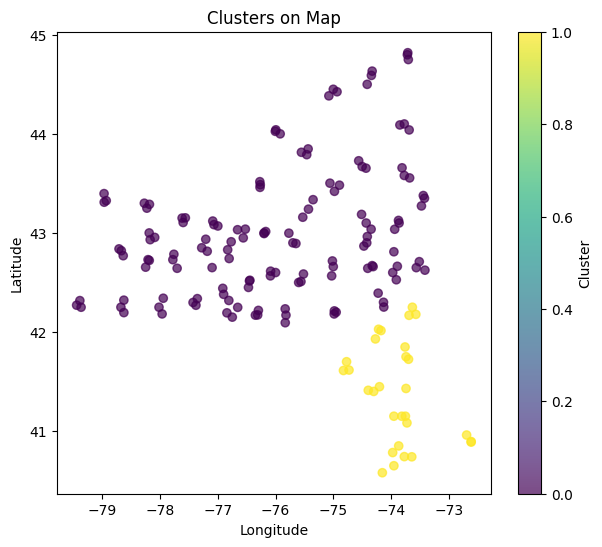

In [34]:
def plot_clusters_on_map(locations_df, cluster_assignments, title="Clusters on Map"):
    """
    Plots each row of `locations_df` colored by its cluster assignment.

    locations_df: pd.DataFrame with columns ['latitude','longitude'], shape=(n_locs,2)
    cluster_assignments: np.ndarray of length n_locs
    """
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(
        x=locations_df['longitude'],
        y=locations_df['latitude'],
        c=cluster_assignments,
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()

# Now plot
plot_clusters_on_map(locations, clusters)